# Demonstrating Violation of Bell's Inequality

This tutorial shows how to run a version of Bell's inequality experiment in Braket on local simulator and different QPUs.  

Till the "Running on QPUs" cell below, you can run this notebook on your own choice of jupyter server without even an AWS account. You may need to install AWS braket sdk. Refer to: https://github.com/aws/amazon-braket-sdk-python 

## EPR state

Consider two spin-1/2 particles in the singlet state:
$$ |\psi^{-}\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle_{Alice}|1\rangle_{\text Bob} - |1\rangle_{Alice}|0\rangle_{\text Bob}  \right).$$

Suppose the particles are separated and sent to different experimentalists: Alice and Bob. The property of interest is that the two particles are entangled. If a measurement on particle 1 along $\mathbf{\hat n}$ gives $+1$, then measuring particle 2 in $\mathbf{\hat n}$ will give $-1$. This is perfect anti-correlation when both particles are measured in the same basis. A remarkable property of quantum mechancis is that this anti-correlation is basis independent. If the pair is entangled, it's entangled in all possible measurement bases. 


What about the case where Alice measures in $\mathbf{\hat n_1}$ and Bob measures in a different directoin $\mathbf{\hat n_2}$? 
It can be shown that the expected value of the measurement outcomes is

$$E^{\psi^{-}}(\mathbf{\hat n_1}, \mathbf{\hat n_2}) = -\cos\left(\theta_{\mathbf{\hat n_1}, \mathbf{\hat n_2}}\right) $$

where $\theta_{\mathbf{\hat n_1}, \mathbf{\hat n_2}}$ is the angle between the two directions.  If $\mathbf{\hat n_1}$ and $\mathbf{\hat n_2}$ are aligned (angle between them is 0), then the results will be perfectly anticorrelated. If they are perpendicular (angle $\pi/2$), the results will be independent.

## Bell's Inequality

Bell's experiment considers that would happen if Alice and Bob each measure in two different directions.Alice will measure in $\mathbf{\hat a}$ and $\mathbf{\hat b}$, while Bob will measure in $\mathbf{\hat b}$ and $\mathbf{\hat c}$.

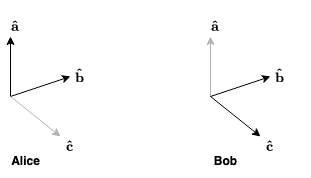


Bell derived that if there was some pre-existing physical property that the measurement "uncovers", and if the measurements are not causally related, then the expectation values of the singlet state must obey:

$$ |P(\mathbf{\hat a}, \mathbf{\hat b})  - P(\mathbf{\hat a}, \mathbf{\hat c})| - P(\mathbf{\hat b}, \mathbf{\hat c})  \leq 1$$

for three directions $\mathbf{\hat a}, \mathbf{\hat b}, \mathbf{\hat c}$. Violation of this inequality undermines the assumptions of local hidden variables to explain entanglement.  This is the original version of Bell's inequality [1]. 

$P(\mathbf{\hat a}, \mathbf{\hat b}) $ is also called correlation or singlet state expectation $E^{\psi^{-}}(\mathbf{\hat a}, \mathbf{\hat b})$. 

Without loss of generality, we choose $\mathbf{\hat a}, \mathbf{\hat b}, \mathbf{\hat c}$ to lie in the $y-z$ plane. We can also choose  $\mathbf{\hat a} = \mathbf{\hat z}$ so that $\mathbf{\hat b}, \mathbf{\hat c}$ are completely defined by their angles $\theta_{\mathbf{\hat b}}$ and $\theta_{\mathbf{\hat c}}$ from the $z$-axis. Bell's inequality then becomes 

$$
|-\cos\theta_{\mathbf{\hat b}} + \cos\theta_{\mathbf{\hat c}}|  + \cos(\theta_{\mathbf{\hat c}}-\theta_{\mathbf{\hat b}}) \leq 1
$$

In the cell below, we plot the lef-hand-side of this equation for various values of  $ \theta_{\mathbf{\hat b}} \ and    \ (\theta_{\mathbf{\hat c}}-\theta_{\mathbf{\hat b}}) $\.

The maximum value is $1.5 \nleq 1$ which occurs at $\theta_{\mathbf{\hat b}}=\pi/3$,  $\theta_{\mathbf{\hat c}} = 2\pi/3$as confirmed in the plot. 

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

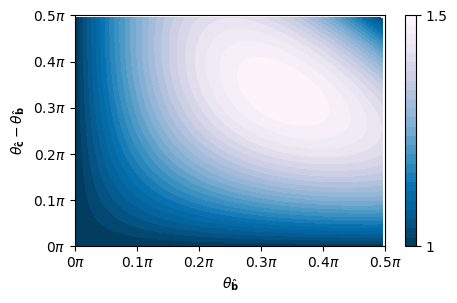

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker

N = 1_00
# b is grid index for angle: theta b
# cmb is grid index for angle: theta c - theta b
b, cmb = np.mgrid[0:N, 0:N] / (2 * N)
bell_terms = np.abs(np.cos(b * np.pi + cmb * np.pi) - np.cos(b * np.pi)) + np.cos(
    cmb * np.pi
)

fig, ax = plt.subplots(figsize=(5, 3))
cs = ax.contourf(b, cmb, bell_terms, cmap=cm.PuBu_r, levels=30)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(r"%g$\pi$"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(r"%g$\pi$"))
cbar = fig.colorbar(cs, ticks=[1, 1.5])
cbar.ax.set_yticklabels(["1", "1.5"])
ax.set(
    xlim=(0, 0.5),
    ylim=(0, 0.5),
    xlabel=r"$\theta_{\mathbf{\hat b}}$",
    ylabel=r"$\theta_{\mathbf{\hat c}}-\theta_{\mathbf{\hat b}}$",
)
plt.show()

## Testing  Bell's inequality on quantum computers

We start by preparing the Bell singlet state in Braket. 

In [3]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator

In [4]:
def bell_singlet(qubit0, qubit1):
    return Circuit().x(qubit0).x(qubit1).h(qubit0).cnot(qubit0, qubit1)

In [5]:
print(bell_singlet(0, 1))

T  : |0|1|2|
            
q0 : -X-H-C-
          | 
q1 : -X---X-

T  : |0|1|2|


In quantum computers we can not make measurement in any aribtrary angle (please refer to documentation about Observable in https://docs.aws.amazon.com/braket/latest/developerguide/braket-result-types.html). But, we can rotate the qubit state by same angle but in opposite direction to achive effectively the same outcome. For example, to effectively measure in basis $\mathbf{\hat b}$ which is in counterclockwise angle $\theta_{\mathbf{\hat b}}$ in the above depicted diagram, we need to rotate the qubit by clockwise by angle $\theta_{\mathbf{\hat b}}$. We can rotate each entangled qubit by different angles and do the measurement effectively in different basis at respective angles.

Next, we want to measure in different basis defined by $\mathbf{\hat b}$ or $\mathbf{\hat c}$. 
Since the directions lie  in the $y-z$ plane, we can get we must rotate the state by by $\theta_{\mathbf{\hat b}}$ and $\theta_{\mathbf{\hat c}}$ around the $x$-axis using a rotation gate $Rx(\theta)$. Alice applies rotation $Rx(\theta)$ on the first spin, and Bob applied $Rx(\theta)$ to the second spin. The three experiments we need to perform are summarized in the table below.

|  | $\text{Alice}$   | $\text{Bob}$  |
| :-: | :-: | :-: |
| AB | $0$     | $\pi/3$  |
| AC | $0$     | $2\pi/3$ |
| BC | $\pi/3$ | $2\pi/3$ |


In [6]:
def bell_singlet_rotated(qubit0, qubit1, rotation0, rotation1):
    c = bell_singlet(qubit0, qubit1)
    if rotation0 != 0:
        c = c.rx(qubit0, rotation0)
    if rotation1 != 0:
        c = c.rx(qubit1, rotation1)
    c.sample(Observable.Z())
    return c

The three Bell circuits to run are:

In [7]:
circAB = bell_singlet_rotated(0, 1, 0, np.pi / 3.0)
circAC = bell_singlet_rotated(0, 1, 0, 2 * np.pi / 3.0)
circBC = bell_singlet_rotated(0, 1, np.pi / 3.0, 2 * np.pi / 3.0)
# printing circBC as an example of the three circuits
print(circBC)

T  : |0|1|2|   3    |Result Types|
                                
q0 : -X-H-C-Rx(1.05)-Sample(Z)----
          |          |          
q1 : -X---X-Rx(2.09)-Sample(Z)----

T  : |0|1|2|   3    |Result Types|


In [8]:
res = [
    LocalSimulator().run(circ, shots=10_000).result().measurement_probabilities
    for circ in [circAB, circAC, circBC]
]
prob_same = [d["00"] + d["11"] for d in res]
prob_different = [d["01"] + d["10"] for d in res]

# P() below refers to expectation or corellation of the measurement of the entangled qubits with value ranging from 1 to -1
pAB, pAC, pBC = np.array(prob_same) - np.array(prob_different)
print(
    f"P(a,b) = {pAB},P(a,c) = {pAC},P(b,c) = {pBC}\nBell inequality: {np.abs(pAB - pAC) - pBC} ≤ 1"
)

P(a,b) = -0.49340000000000006,P(a,c) = 0.5224,P(b,c) = -0.4778
Bell inequality: 1.4936 ≤ 1


The Bell inequality is violated just as predicted by quantum mechanics by the simulator! Some times you may see inequality values little bit above 1.5 depending on the quantum randomness simulated by the simulator eventhough theoretical maximum is 1.5.

Let's wrap those steps into couple of python functions so we can easily run on different QPUs.

In [9]:
def submit_bell_tasks(device, shots=1_000):
    circAB = bell_singlet_rotated(0, 1, 0, np.pi / 3.0)
    circAC = bell_singlet_rotated(0, 1, 0, 2 * np.pi / 3.0)
    circBC = bell_singlet_rotated(0, 1, np.pi / 3.0, 2 * np.pi / 3.0)
    tasks = [device.run(circ, shots=shots) for circ in [circAB, circAC, circBC]]
    return tasks


def get_results(tasks, verbose=True):
    results = [task.result().measurement_probabilities for task in tasks]
    prob_same = [d["00"] + d["11"] for d in results]
    prob_different = [d["01"] + d["10"] for d in results]
    pAB, pAC, pBC = np.array(prob_same) - np.array(prob_different)
    bell_ineqality_lhs=np.abs(pAB - pAC) - pBC
    if verbose == True:
        print(
            f"P(a,b) = {pAB},P(a,c) = {pAC},P(b,c) = {pBC}\nBell\'s' inequality: {bell_ineqality_lhs} ≤ 1"
        )
        if bell_ineqality_lhs>1:
            print("Bell\'s inequality is violated!")
            print("Notice that the quantity is not exactly 1.5 as predicted by theory. This is may be due to less number shots or the effects of noise on the QPU.")
        else:
            print("Bell\'s inequality is not violated due to noise.")
    return results, pAB, pAC, pBC

Test the above functions by running on local simulator.

In [10]:
local_sim = LocalSimulator()
local_sim_tasks = submit_bell_tasks(local_sim)

In [11]:
results, pAB, pAC, pBC = get_results(local_sim_tasks)

P(a,b) = -0.544,P(a,c) = 0.52,P(b,c) = -0.51
Bell's' inequality: 1.574 ≤ 1
Bell's inequality is violated!
Notice that the quantity is not exactly 1.5 as predicted by theory. This is may be due to less number shots or the effects of noise on the QPU.


# Running on QPUs
Following need AWS account as they run on AWS QPUs.

If below QPU related cells taking a long time, you can check the task status in braket console tasks page in the right region. QPU avaiability hours differ and documented in the braket console devices page. You can also export this notebook as a python program and submit it as a braket job in the console.

First we test the Bell inequality on OQC Lucy device. The cost to run this experiment is $\$ 0.3$ per task and $\$0.00035$ per shot.  Since we have three circuits of 1000 shots each, that totals $\$1.95$ USD.

**Cost: $\$1.95$ USD**

In [12]:
oqc_lucy = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
oqc_tasks = submit_bell_tasks(oqc_lucy)

In [13]:
results, pAB, pAC, pBC = get_results(oqc_tasks)

P(a,b) = -0.38399999999999995,P(a,c) = 0.4140000000000001,P(b,c) = 0.12599999999999995
Bell's' inequality: 0.6720000000000002 ≤ 1
Bell's inequality is not violated due to noise.


Next, we submit our example Bell state circuit to IonQ. This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

**Cost: $\$30$ USD**

In [14]:
ionq_harmony = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
ionq_tasks = submit_bell_tasks(ionq_harmony)

In [15]:
results, pAB, pAC, pBC = get_results(ionq_tasks)

P(a,b) = -0.42600000000000005,P(a,c) = 0.44399999999999995,P(b,c) = -0.5379999999999999
Bell's' inequality: 1.408 ≤ 1
Bell's inequality is violated!
Notice that the quantity is not exactly 1.5 as predicted by theory. This is may be due to less number shots or the effects of noise on the QPU.


In [16]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy': {'shots': 3000, 'tasks': {'COMPLETED': 3}}, 'arn:aws:braket:::device/qpu/ionq/ionQdevice': {'shots': 3000, 'tasks': {'COMPLETED': 3}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 32.85 USD


## Related non-peer reviewed links:

https://en.wikipedia.org/wiki/Singlet_state#Singlets_and_entangled_states

https://en.wikipedia.org/wiki/Bell%27s_theorem#Bell_(1964)

## References

[1]  Bell, J. S. On the Einstein Podolsky Rosen Paradox. Physics Physique Fizika 1, no. 3 (November 1, 1964): 195–200. https://doi.org/10.1103/PhysicsPhysiqueFizika.1.195.


[2] Greenberger, Daniel M., Michael A. Horne, Abner Shimony, and Anton Zeilinger (1990). Bell’s Theorem without Inequalities. American Journal of Physics 58, no. 12: 1131–43. https://doi.org/10.1119/1.16243.
